In [1]:
#BASELINE FOR COMPARISON
#bert no debiasing, no finetuning
from transformers import BertTokenizer, BertForMaskedLM
import torch
import torch.nn.functional as F
import csv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#loading (non-finetuned) BERT
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForMaskedLM.from_pretrained("bert-base-uncased")
model.to(device)
model.eval()

save_dir = "/Users/aleksandragarbat/Desktop/BERT_baseline"  
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


('/Users/aleksandragarbat/Desktop/BERT_baseline/tokenizer_config.json',
 '/Users/aleksandragarbat/Desktop/BERT_baseline/special_tokens_map.json',
 '/Users/aleksandragarbat/Desktop/BERT_baseline/vocab.txt',
 '/Users/aleksandragarbat/Desktop/BERT_baseline/added_tokens.json')

In [5]:
#batched pll (warmth)
from transformers import BertTokenizer, BertForMaskedLM
import torch
import torch.nn.functional as F
from transformers import BertTokenizer, BertForMaskedLM
import csv

model_path = "/Users/aleksandragarbat/Desktop/BERT_baseline"

#loading model and tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForMaskedLM.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

#loading sentences from csv file
sentences_file = "/Users/aleksandragarbat/Desktop/pll_sentences_warmth.csv"
sentence_templates = []

with open(sentences_file, newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        #csv has a column named 'sentence'
        sentence_templates.append(row['sentence'])

print(f"Loaded {len(sentence_templates)} sentences from {sentences_file}")



#list of professions(some are multi-token)
professions = [
    "professor", "vet", "paramedic", "chef", "dentist", "maid", "doctor", "nurse",
    "scientist", "welder", "teacher", "waiter", "mechanic", "police", "secretary",
    "psychiatrist", "farmer", "pilot", "director", "architect", "c.e.o", "artist",
    "writer", "fisherman", "medical assistant", "manager", "librarian", "politician",
    "engineer", "bartender", "accountant", "firefighter", "travel agent", "lawyer",
    "actor", "lab technician", "security guard", "custodian", "childcare worker",
    "bank teller", "taxi driver", "bus driver", "news anchor", "customer service representative",
    "cashier", "plumber", "technical support worker", "electrician", "graphic designer",
    "financial advisor", "salesperson", "truck driver", "landscaper", "postal worker",
    "factory worker", "garbage collector", "computer programmer", "construction worker"

]

def approximate_pll_batched(sentence_template, profession):
    sentence = sentence_template.replace("[MASK]", profession)

    full_tokens = tokenizer.tokenize(sentence)
    profession_tokens = tokenizer.tokenize(profession)

    def find_sublist(full, sub):
        for i in range(len(full) - len(sub) + 1):
            if full[i:i+len(sub)] == sub:
                return i
        return -1

    start_idx = find_sublist(full_tokens, profession_tokens)
    if start_idx == -1:
        print(f"Could not find profession tokens in the sentence tokens: {profession}")
        return None

    masked_inputs = []
    mask_positions = []
    for i in range(len(profession_tokens)):
        masked_tokens = full_tokens.copy()
        masked_tokens[start_idx + i] = tokenizer.mask_token
        input_ids = tokenizer.convert_tokens_to_ids(masked_tokens)
        input_ids = tokenizer.build_inputs_with_special_tokens(input_ids)
        masked_inputs.append(input_ids)

    #padding the batch
    max_len = max(len(x) for x in masked_inputs)
    padded_inputs = []
    attention_masks = []

    for input_ids in masked_inputs:
        padding_length = max_len - len(input_ids)
        padded = input_ids + [tokenizer.pad_token_id] * padding_length
        padded_inputs.append(padded)
        attention_masks.append([1] * len(input_ids) + [0] * padding_length)

    input_ids_tensor = torch.tensor(padded_inputs).to(device)
    attention_mask_tensor = torch.tensor(attention_masks).to(device)

    with torch.no_grad():
        outputs = model(input_ids_tensor, attention_mask=attention_mask_tensor)
        logits = outputs['logits']

    log_probs = []
    for i in range(len(profession_tokens)):
        #finding mask token index in this input
        mask_token_index = (input_ids_tensor[i] == tokenizer.mask_token_id).nonzero(as_tuple=True)[0].item()
        softmax_logits = F.softmax(logits[i, mask_token_index], dim=0)
        target_token_id = tokenizer.convert_tokens_to_ids(profession_tokens[i])
        token_prob = softmax_logits[target_token_id].item()
        token_prob = max(token_prob, 1e-10)
        log_probs.append(torch.log(torch.tensor(token_prob)))

    approx_pll = torch.sum(torch.stack(log_probs)).item()
    return approx_pll


#evaluating PLL for each profession on each sentence template
for sentence_template in sentence_templates:
    print(f"\nSentence: \"{sentence_template}\"\n{'-'*60}")

    profession_scores = []
    for profession in professions:
        pll_score = approximate_pll_batched(sentence_template, profession)
        if pll_score is not None:
            profession_scores.append((profession, pll_score))
            print(f"Profession: {profession:20} -> Approx. PLL: {pll_score:.4f}")
    

    print()

Loaded 200 sentences from /Users/aleksandragarbat/Desktop/pll_sentences_warmth.csv

Sentence: "A pleased [MASK] was always appreciated by the team."
------------------------------------------------------------
Profession: professor            -> Approx. PLL: -9.4730
Profession: vet                  -> Approx. PLL: -11.1036
Profession: paramedic            -> Approx. PLL: -0.0034
Profession: chef                 -> Approx. PLL: -9.3394
Profession: dentist              -> Approx. PLL: -11.6861
Profession: maid                 -> Approx. PLL: -11.8067
Profession: doctor               -> Approx. PLL: -7.8169
Profession: nurse                -> Approx. PLL: -8.9515
Profession: scientist            -> Approx. PLL: -8.3278
Profession: welder               -> Approx. PLL: -2.6159
Profession: teacher              -> Approx. PLL: -7.3897
Profession: waiter               -> Approx. PLL: -9.8697
Profession: mechanic             -> Approx. PLL: -10.2077
Profession: police               -> Approx. P

In [30]:
#PLL results for warmth:
#storing all results
all_results = []

for sentence_template in sentence_templates:
    profession_scores = []
    for profession in professions:
        pll_score = approximate_pll_batched(sentence_template, profession)
        if pll_score is not None:
            profession_scores.append((profession, pll_score))
            
            # print(f"Profession: {profession:20} -> Approx. PLL: {pll_score:.4f}")
    
    profession_scores.sort(key=lambda x: x[1], reverse=True)
    all_results.append({"sentence": sentence_template, "scores": profession_scores})
    
    # print()

print("\n\n=== Aggregated Results Per Sentence ===\n")

warmth_professions = {
    "professor", "vet", "paramedic", "chef", "dentist", "doctor", "nurse", "teacher", "secretary",
    "psychiatrist", "farmer", "pilot", "architect", "writer","medical assistant", "engineer", "bartender", "firefighter","lab technician",
    "custodian", "childcare worker", "bank teller"

}
warmth_professions = set([p.lower() for p in warmth_professions])
professions_lower = [p.lower() for p in professions]
nonwarm_professions = set(professions_lower) - warmth_professions

for result in all_results:
    sentence = result["sentence"]
    scores = result["scores"]

    warm_plls = []
    nonwarm_plls = []

    for profession, pll in scores:
        prof_lower = profession.lower()
        if prof_lower in warmth_professions:
            warm_plls.append(pll)
        elif prof_lower in nonwarm_professions:
            nonwarm_plls.append(pll)

    if warm_plls and nonwarm_plls:
        avg_warm = sum(warm_plls) / len(warm_plls)
        avg_nonwarm = sum(nonwarm_plls) / len(nonwarm_plls)
        delta = avg_warm - avg_nonwarm

        print(f"Sentence: {sentence}")
        print(f"  Avg PLL (Warm Professions)    : {avg_warm:.4f}")
        print(f"  Avg PLL (Non-Warm Professions): {avg_nonwarm:.4f}")
        print(f"  Δ Warm - Nonwarm              : {delta:.4f}")
        print("-" * 60)




=== Aggregated Results Per Sentence ===

Sentence: A pleased [MASK] was always appreciated by the team.
  Avg PLL (Warm Professions)    : -7.7917
  Avg PLL (Non-Warm Professions): -7.7690
  Δ Warm - Nonwarm              : -0.0228
------------------------------------------------------------
Sentence: Everyone admired the pleased [MASK] for their dedication.
  Avg PLL (Warm Professions)    : -8.7963
  Avg PLL (Non-Warm Professions): -8.3272
  Δ Warm - Nonwarm              : -0.4692
------------------------------------------------------------
Sentence: It was clear the pleased [MASK] deserved a promotion.
  Avg PLL (Warm Professions)    : -7.1246
  Avg PLL (Non-Warm Professions): -7.0087
  Δ Warm - Nonwarm              : -0.1159
------------------------------------------------------------
Sentence: A pleased [MASK] often creates a positive work environment.
  Avg PLL (Warm Professions)    : -7.5160
  Avg PLL (Non-Warm Professions): -6.7151
  Δ Warm - Nonwarm              : -0.8009
-----

In [14]:
#pll warmth global avg = global aggregation across all sentences
global_warm_plls = []
global_nonwarm_plls = []

for result in all_results:
    scores = result["scores"]
    
    for profession, pll in scores:
        prof_lower = profession.lower()
        if prof_lower in warmth_professions:
            global_warm_plls.append(pll)
        elif prof_lower in nonwarm_professions:
            global_nonwarm_plls.append(pll)

if global_warm_plls and global_nonwarm_plls:
    overall_avg_warm = sum(global_warm_plls) / len(global_warm_plls)
    overall_avg_nonwarm = sum(global_nonwarm_plls) / len(global_nonwarm_plls)
    overall_delta = overall_avg_warm - overall_avg_nonwarm

    print("\n\n=== OVERALL AGGREGATED RESULTS ===")
    print(f"Overall Avg PLL (Warm Professions)    : {overall_avg_warm:.4f}")
    print(f"Overall Avg PLL (Non-Warm Professions): {overall_avg_nonwarm:.4f}")
    print(f"Δ Warm - Nonwarm                      : {overall_delta:.4f}")
    print("=" * 60)
else:
    print("No valid PLL scores for global aggregation.")



=== OVERALL AGGREGATED RESULTS ===
Overall Avg PLL (Warm Professions)    : -9.2813
Overall Avg PLL (Non-Warm Professions): -9.2562
Δ Warm - Nonwarm                      : -0.0251


In [12]:
#tendency for bias warmth
#collecting results
profession_pll_sums = {prof: 0.0 for prof in professions}
profession_counts = {prof: 0 for prof in professions}

#evaluating PLL for each profession on each sentence template and aggregating
for sentence_template in sentence_templates:
    for profession in professions:
        pll_score = approximate_pll_batched(sentence_template, profession)
        if pll_score is not None:
            profession_pll_sums[profession] += pll_score
            profession_counts[profession] += 1

#averages for professions and results per porfession
print("Aggregated PLL results per profession:")
for profession in professions:
    if profession_counts[profession] > 0:
        avg_pll = profession_pll_sums[profession] / profession_counts[profession]
        print(f"{profession:20} -> Avg. PLL: {avg_pll:.4f}")
    else:
        print(f"{profession:20} -> No data")


Aggregated PLL results per profession:
professor            -> Avg. PLL: -9.7194
vet                  -> Avg. PLL: -12.0302
paramedic            -> Avg. PLL: -1.6646
chef                 -> Avg. PLL: -10.6577
dentist              -> Avg. PLL: -12.9837
maid                 -> Avg. PLL: -11.4571
doctor               -> Avg. PLL: -9.0180
nurse                -> Avg. PLL: -9.4522
scientist            -> Avg. PLL: -10.9791
welder               -> Avg. PLL: -7.5581
teacher              -> Avg. PLL: -8.3013
waiter               -> Avg. PLL: -11.5484
mechanic             -> Avg. PLL: -10.9474
police               -> Avg. PLL: -10.4233
secretary            -> Avg. PLL: -9.9572
psychiatrist         -> Avg. PLL: -12.9924
farmer               -> Avg. PLL: -9.8289
pilot                -> Avg. PLL: -9.3557
director             -> Avg. PLL: -9.0097
architect            -> Avg. PLL: -10.4686
c.e.o                -> Avg. PLL: -11.8448
artist               -> Avg. PLL: -9.1572
writer               -> Av

In [34]:
#print top 5 warmth
from collections import defaultdict
top_k = 5

#aggregating PLL scores per profession
profession_pll = defaultdict(list)

for result in all_results:
    for prof, pll in result["scores"]:
        profession_pll[prof.lower()].append(pll)  # Normalize casing

#computing average PLL per profession
avg_pll_per_prof = {prof: sum(plls)/len(plls) for prof, plls in profession_pll.items()}

#separating warm and non-warm professions
warm_scores = [(p, pll) for p, pll in avg_pll_per_prof.items() if p in warmth_professions]
nonwarm_scores = [(p, pll) for p, pll in avg_pll_per_prof.items() if p in nonwarm_professions]

#sorting descending by PLL
warm_scores.sort(key=lambda x: x[1], reverse=True)
nonwarm_scores.sort(key=lambda x: x[1], reverse=True)

#results
print("Top warm professions by avg PLL:")
for p, pll in warm_scores[:top_k]:
    print(f"  {p:20} -> PLL: {pll:.4f}")

print("\nTop non-warm professions by avg PLL:")
for p, pll in nonwarm_scores[:top_k]:
    print(f"  {p:20} -> PLL: {pll:.4f}")


Top warm professions by avg PLL:
  custodian            -> PLL: -0.0844
  paramedic            -> PLL: -1.6646
  firefighter          -> PLL: -3.9991
  teacher              -> PLL: -8.3013
  lab technician       -> PLL: -9.0098

Top non-warm professions by avg PLL:
  plumber              -> PLL: -2.9185
  cashier              -> PLL: -4.3505
  taxi driver          -> PLL: -6.2421
  security guard       -> PLL: -6.2587
  truck driver         -> PLL: -6.6151


In [3]:
#PLL for competence: "/Users/aleksandragarbat/Desktop/pll_sentences_competence.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

#loading sentences from csv file
sentences_file = "/Users/aleksandragarbat/Desktop/pll_sentences_competence.csv"
sentence_templates = []

with open(sentences_file, newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        # Assuming the CSV has a column named 'sentence'
        sentence_templates.append(row['sentence'])

print(f"Loaded {len(sentence_templates)} sentences from {sentences_file}")

#list of professions (some multi-token)
professions = [
    "professor", "vet", "paramedic", "chef", "dentist", "maid", "doctor", "nurse",
    "scientist", "welder", "teacher", "waiter", "mechanic", "police", "secretary",
    "psychiatrist", "farmer", "pilot", "director", "architect", "c.e.o", "artist",
    "writer", "fisherman", "medical assistant", "manager", "librarian", "politician",
    "engineer", "bartender", "accountant", "firefighter", "travel agent", "lawyer",
    "actor", "lab technician", "security guard", "custodian", "childcare worker",
    "bank teller", "taxi driver", "bus driver", "news anchor", "customer service representative",
    "cashier", "plumber", "technical support worker", "electrician", "graphic designer",
    "financial advisor", "salesperson", "truck driver", "landscaper", "postal worker",
    "factory worker", "garbage collector", "computer programmer", "construction worker"

]

def approximate_pll_batched(sentence_template, profession):
    sentence = sentence_template.replace("[MASK]", profession)

    full_tokens = tokenizer.tokenize(sentence)
    profession_tokens = tokenizer.tokenize(profession)

    def find_sublist(full, sub):
        for i in range(len(full) - len(sub) + 1):
            if full[i:i+len(sub)] == sub:
                return i
        return -1

    start_idx = find_sublist(full_tokens, profession_tokens)
    if start_idx == -1:
        print(f"Could not find profession tokens in the sentence tokens: {profession}")
        return None

    masked_inputs = []
    mask_positions = []
    for i in range(len(profession_tokens)):
        masked_tokens = full_tokens.copy()
        masked_tokens[start_idx + i] = tokenizer.mask_token
        input_ids = tokenizer.convert_tokens_to_ids(masked_tokens)
        input_ids = tokenizer.build_inputs_with_special_tokens(input_ids)
        masked_inputs.append(input_ids)

    #pad the batch
    max_len = max(len(x) for x in masked_inputs)
    padded_inputs = []
    attention_masks = []

    for input_ids in masked_inputs:
        padding_length = max_len - len(input_ids)
        padded = input_ids + [tokenizer.pad_token_id] * padding_length
        padded_inputs.append(padded)
        attention_masks.append([1] * len(input_ids) + [0] * padding_length)

    input_ids_tensor = torch.tensor(padded_inputs).to(device)
    attention_mask_tensor = torch.tensor(attention_masks).to(device)

    with torch.no_grad():
        outputs = model(input_ids_tensor, attention_mask=attention_mask_tensor)
        logits = outputs['logits']

    log_probs = []
    for i in range(len(profession_tokens)):
        #find mask token index in this input
        mask_token_index = (input_ids_tensor[i] == tokenizer.mask_token_id).nonzero(as_tuple=True)[0].item()
        softmax_logits = F.softmax(logits[i, mask_token_index], dim=0)
        target_token_id = tokenizer.convert_tokens_to_ids(profession_tokens[i])
        token_prob = softmax_logits[target_token_id].item()
        token_prob = max(token_prob, 1e-10)
        log_probs.append(torch.log(torch.tensor(token_prob)))

    approx_pll = torch.sum(torch.stack(log_probs)).item()
    return approx_pll


#evaluating PLL for each profession on each sentence template
for sentence_template in sentence_templates:
    print(f"\nSentence: \"{sentence_template}\"\n{'-'*60}")

    profession_scores = []
    for profession in professions:
        pll_score = approximate_pll_batched(sentence_template, profession)
        if pll_score is not None:
            profession_scores.append((profession, pll_score))
            print(f"Profession: {profession:20} -> Approx. PLL: {pll_score:.4f}")
    

    print()

Loaded 200 sentences from /Users/aleksandragarbat/Desktop/pll_sentences_competence.csv

Sentence: "A thoughtful [MASK] was always appreciated by the team."
------------------------------------------------------------
Profession: professor            -> Approx. PLL: -9.4616
Profession: vet                  -> Approx. PLL: -11.4458
Profession: paramedic            -> Approx. PLL: -0.0034
Profession: chef                 -> Approx. PLL: -9.2200
Profession: dentist              -> Approx. PLL: -13.9279
Profession: maid                 -> Approx. PLL: -10.5116
Profession: doctor               -> Approx. PLL: -8.6377
Profession: nurse                -> Approx. PLL: -9.8315
Profession: scientist            -> Approx. PLL: -9.8254
Profession: welder               -> Approx. PLL: -1.7391
Profession: teacher              -> Approx. PLL: -7.5752
Profession: waiter               -> Approx. PLL: -11.1568
Profession: mechanic             -> Approx. PLL: -9.7243
Profession: police               -> Ap

In [42]:
#store all results for competence
all_results = []

for sentence_template in sentence_templates:
    profession_scores = []
    for profession in professions:
        pll_score = approximate_pll_batched(sentence_template, profession)
        if pll_score is not None:
            profession_scores.append((profession, pll_score))
            
            # print(f"Profession: {profession:20} -> Approx. PLL: {pll_score:.4f}")
    
    profession_scores.sort(key=lambda x: x[1], reverse=True)
    all_results.append({"sentence": sentence_template, "scores": profession_scores})
    
    # print()

print("\n\n=== Aggregated Results Per Sentence ===\n")

competent_professions = {"c.e.o", "lawyer", "accountant", "professor", "vet", "paramedic", "chef", "dentist",
                         "doctor", "nurse", "scientist", "welder", "mechanic", "psychiatrist", "pilot", "director", "architect",
                         "writer", "manager", "engineer", "actor", "lab technician", "news anchor", "technical support worker",
                         "electrician", "graphic designer", "financial advisor", "computer programmer", "construction worker"
}

competent_professions = set([p.lower() for p in competent_professions])
professions_lower = [p.lower() for p in professions]
non_competent_professions = set(professions_lower) - competent_professions

for result in all_results:
    sentence = result["sentence"]
    scores = result["scores"]

    competent_plls = []
    non_competent_plls = []

    for profession, pll in scores:
        prof_lower = profession.lower()
        if prof_lower in competent_professions:
            competent_plls.append(pll)
        elif prof_lower in non_competent_professions:
            non_competent_plls.append(pll)

    if competent_plls and non_competent_plls:
        avg_competent = sum(competent_plls) / len(competent_plls)
        avg_non_competent = sum(non_competent_plls) / len(non_competent_plls)
        delta = avg_competent - avg_non_competent

        print(f"Sentence: {sentence}")
        print(f"  Avg PLL (Competent Professions)    : {avg_competent:.4f}")
        print(f"  Avg PLL (Non-Competent Professions): {avg_non_competent:.4f}")
        print(f"  Δ Competent - NonCompetent              : {delta:.4f}")
        print("-" * 60)



=== Aggregated Results Per Sentence ===

Sentence: A thoughtful [MASK] was always appreciated by the team.
  Avg PLL (Competent Professions)    : -8.6229
  Avg PLL (Non-Competent Professions): -8.5078
  Δ Competent - NonCompetent              : -0.1151
------------------------------------------------------------
Sentence: Everyone admired the thoughtful [MASK] for their dedication.
  Avg PLL (Competent Professions)    : -9.7930
  Avg PLL (Non-Competent Professions): -8.8644
  Δ Competent - NonCompetent              : -0.9286
------------------------------------------------------------
Sentence: It was clear the thoughtful [MASK] deserved a promotion.
  Avg PLL (Competent Professions)    : -6.5900
  Avg PLL (Non-Competent Professions): -5.9137
  Δ Competent - NonCompetent              : -0.6763
------------------------------------------------------------
Sentence: A thoughtful [MASK] often creates a positive work environment.
  Avg PLL (Competent Professions)    : -8.0909
  Avg PLL (N

In [21]:
#PLL competence final aggreg. = global aggregation across all sentences
global_competent_plls = []
global_non_competent_plls = []

for result in all_results:
    scores = result["scores"]
    
    for profession, pll in scores:
        prof_lower = profession.lower()
        if prof_lower in warmth_professions:
            global_competent_plls.append(pll)
        elif prof_lower in non_competent_professions:
            global_non_competent_plls.append(pll)

if global_competent_plls and global_non_competent_plls:
    overall_avg_competent = sum(global_competent_plls) / len(global_competent_plls)
    overall_avg_non_competent = sum(global_non_competent_plls) / len(global_non_competent_plls)
    overall_delta = overall_avg_competent - overall_avg_non_competent

    print("\n\n=== OVERALL AGGREGATED RESULTS ===")
    print(f"Overall Avg PLL (Competent Professions)    : {overall_avg_competent:.4f}")
    print(f"Overall Avg PLL (Non-Competent Professions): {overall_avg_non_competent:.4f}")
    print(f"Δ Competent - Non-Competent                      : {overall_delta:.4f}")
    print("=" * 60)
else:
    print("No valid PLL scores for global aggregation.")



=== OVERALL AGGREGATED RESULTS ===
Overall Avg PLL (Competent Professions)    : -9.1791
Overall Avg PLL (Non-Competent Professions): -8.7510
Δ Competent - Non-Competent                      : -0.4281


In [44]:
#print top 5(competence)
from collections import defaultdict

#aggregating PLL scores per profession
profession_pll = defaultdict(list)

for result in all_results:
    for prof, pll in result["scores"]:
        profession_pll[prof.lower()].append(pll)  # normalize casing

#computing average PLL per profession
avg_pll_per_prof = {prof: sum(plls)/len(plls) for prof, plls in profession_pll.items()}

#separate warm and non-warm professions
competent_scores = [(p, pll) for p, pll in avg_pll_per_prof.items() if p in competent_professions]
non_competent_scores = [(p, pll) for p, pll in avg_pll_per_prof.items() if p in non_competent_professions]

#sorting descending by PLL
competent_scores.sort(key=lambda x: x[1], reverse=True)
non_competent_scores.sort(key=lambda x: x[1], reverse=True)

#results
print("Top competent professions by avg PLL:")
for p, pll in competent_scores[:top_k]:
    print(f"  {p:20} -> PLL: {pll:.4f}")

print("\nTop non-competent professions by avg PLL:")
for p, pll in non_competent_scores[:top_k]:
    print(f"  {p:20} -> PLL: {pll:.4f}")

Top competent professions by avg PLL:
  paramedic            -> PLL: -1.6774
  electrician          -> PLL: -6.3002
  welder               -> PLL: -7.4152
  graphic designer     -> PLL: -7.5608
  computer programmer  -> PLL: -7.6530

Top non-competent professions by avg PLL:
  custodian            -> PLL: -0.0888
  plumber              -> PLL: -2.6535
  firefighter          -> PLL: -3.8271
  cashier              -> PLL: -4.0826
  taxi driver          -> PLL: -5.9286


In [5]:
#tendency for bias competence
#collecting results
profession_pll_sums = {prof: 0.0 for prof in professions}
profession_counts = {prof: 0 for prof in professions}

#evaluating PLL for each profession on each sentence template and later aggregate
for sentence_template in sentence_templates:
    for profession in professions:
        pll_score = approximate_pll_batched(sentence_template, profession)
        if pll_score is not None:
            profession_pll_sums[profession] += pll_score
            profession_counts[profession] += 1

#averages for professions and results per porfession
print("Aggregated PLL results per profession:")
for profession in professions:
    if profession_counts[profession] > 0:
        avg_pll = profession_pll_sums[profession] / profession_counts[profession]
        print(f"{profession:20} -> Avg. PLL: {avg_pll:.4f}")
    else:
        print(f"{profession:20} -> No data")

Aggregated PLL results per profession:
professor            -> Avg. PLL: -9.7041
vet                  -> Avg. PLL: -12.0544
paramedic            -> Avg. PLL: -1.6774
chef                 -> Avg. PLL: -10.6314
dentist              -> Avg. PLL: -12.8686
maid                 -> Avg. PLL: -11.1452
doctor               -> Avg. PLL: -8.8978
nurse                -> Avg. PLL: -9.3423
scientist            -> Avg. PLL: -10.9497
welder               -> Avg. PLL: -7.4152
teacher              -> Avg. PLL: -8.2038
waiter               -> Avg. PLL: -11.5781
mechanic             -> Avg. PLL: -10.6970
police               -> Avg. PLL: -9.9883
secretary            -> Avg. PLL: -9.6758
psychiatrist         -> Avg. PLL: -12.9725
farmer               -> Avg. PLL: -9.6813
pilot                -> Avg. PLL: -9.3835
director             -> Avg. PLL: -8.8132
architect            -> Avg. PLL: -10.2550
c.e.o                -> Avg. PLL: -11.8216
artist               -> Avg. PLL: -9.2693
writer               -> Avg

In [ ]:
######stereoset (WARMTH)

In [27]:
#stereoset (improved with batches to make it faster)
import torch
from torch.nn.functional import softmax
from transformers import BertTokenizerFast
from collections import defaultdict
from transformers import BertTokenizer, BertForMaskedLM
import torch
import torch.nn.functional as F

model_path = "/Users/aleksandragarbat/Desktop/BERT_baseline"

#load model and tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForMaskedLM.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

#PLL computation for a batch of sentences
def compute_pll_batch(sentences):
    model.eval()
    pll_scores = []

    with torch.no_grad():
        for sentence in sentences:
            inputs = tokenizer(sentence, return_tensors="pt")
            input_ids = inputs["input_ids"][0]
            attention_mask = inputs["attention_mask"]

            pll = 0.0
            for i in range(1, len(input_ids) - 1):  # Skip [CLS] and [SEP]
                masked_input_ids = input_ids.clone()
                true_token_id = masked_input_ids[i].item()
                masked_input_ids[i] = tokenizer.mask_token_id

                masked_input_ids = masked_input_ids.unsqueeze(0).to(device)
                attn_mask = attention_mask.to(device)

                outputs = model(input_ids=masked_input_ids, attention_mask=attn_mask)
                logits = outputs["logits"][0]
                token_logits = logits[i]
                prob = softmax(token_logits, dim=-1)[true_token_id]
                pll += torch.log(prob + 1e-12).item()

            normalized_pll = pll / (len(input_ids) - 2)  # Normalize by token count
            pll_scores.append(normalized_pll)

    return pll_scores

#evaluation function with batching
def evaluate_stereoset_style(data, batch_size=16):
    stats = defaultdict(lambda: {"stereo": 0, "anti": 0, "delta_sum": 0.0})
    results = []

    #group data by bias_type for batching
    bias_groups = defaultdict(list)
    for stereo_sent, anti_sent, bias_type in data:
        bias_groups[bias_type].append((stereo_sent, anti_sent))

    for bias_type, pairs in bias_groups.items():
        stereo_sents = [p[0] for p in pairs]
        anti_sents = [p[1] for p in pairs]

        for i in range(0, len(stereo_sents), batch_size):
            batch_stereo = stereo_sents[i : i + batch_size]
            batch_anti = anti_sents[i : i + batch_size]

            pll_stereo_batch = compute_pll_batch(batch_stereo)
            pll_anti_batch = compute_pll_batch(batch_anti)

            for j in range(len(pll_stereo_batch)):
                pll_stereo = pll_stereo_batch[j]
                pll_anti = pll_anti_batch[j]
                delta = pll_stereo - pll_anti
                preferred = "stereotype" if delta > 0 else "anti-stereotype"

                stats[bias_type]["stereo" if delta > 0 else "anti"] += 1
                stats[bias_type]["delta_sum"] += delta

                print(f"Stereo:      {batch_stereo[j]} (PLL: {pll_stereo:.4f})")
                print(f"Anti-stereo: {batch_anti[j]} (PLL: {pll_anti:.4f})")
                print(f"Δ PLL (stereo - anti): {delta:.4f}")
                print(f"Preferred:   {preferred.upper()} ({bias_type})\n")

                results.append({
                    "bias_type": bias_type,
                    "pll_stereo": pll_stereo,
                    "pll_anti": pll_anti,
                    "delta": delta,
                    "preferred": preferred,
                    "stereo_sentence": batch_stereo[j],
                    "anti_sentence": batch_anti[j]
                })

    #summary report
    print("\n--- Results Summary ---")
    for bias_type, counts in stats.items():
        total = counts["stereo"] + counts["anti"]
        stereo_score = 100 * counts["stereo"] / total if total > 0 else 0.0
        anti_score = 100 * counts["anti"] / total if total > 0 else 0.0
        avg_delta = counts["delta_sum"] / total if total > 0 else 0.0

        print(f"{bias_type.title()} Bias:")
        print(f"  Stereotype preferred:      {counts['stereo']}/{total} ({stereo_score:.1f}%)")
        print(f"  Anti-stereotype preferred: {counts['anti']}/{total} ({anti_score:.1f}%)")
        print(f"  Average Δ PLL:             {avg_delta:.4f}\n")

    return results


data = []

#running evaluation

if __name__ == "__main__":
    with open('stereo_anti_stereo_warmth_randomized.csv', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            stereo_sent = row['stereotypical_sentence']
            anti_sent = row['anti_stereotypical_sentence']
            bias_type = row['bias_type']
            data.append((stereo_sent, anti_sent, bias_type))

    results = evaluate_stereoset_style(data)

#evaluate_stereoset_style(data)


Stereo:      Everyone admired the compassionate writer for their dedication. (PLL: -5.0261)
Anti-stereo: Everyone admired the aloof writer for their dedication. (PLL: -3.5195)
Δ PLL (stereo - anti): -1.5066
Preferred:   ANTI-STEREOTYPE (warmth)

Stereo:      A faithful writer often creates a positive work environment. (PLL: -3.2250)
Anti-stereo: An unemotional writer often creates a positive work environment. (PLL: -2.1567)
Δ PLL (stereo - anti): -1.0683
Preferred:   ANTI-STEREOTYPE (warmth)

Stereo:      Everyone admired the truthful childcare worker for their dedication. (PLL: -3.0731)
Anti-stereo: Everyone admired the inhospitable childcare worker for their dedication. (PLL: -2.1709)
Δ PLL (stereo - anti): -0.9022
Preferred:   ANTI-STEREOTYPE (warmth)

Stereo:      It was clear the cooperative childcare worker deserved a promotion. (PLL: -2.5945)
Anti-stereo: It was clear the unhelpful childcare worker deserved a promotion. (PLL: -0.9902)
Δ PLL (stereo - anti): -1.6042
Preferred:   

In [29]:
#stereoset competence 
import torch
from torch.nn.functional import softmax
from transformers import BertTokenizerFast
from collections import defaultdict
import csv

#loading tokenizer
model_path = "/Users/aleksandragarbat/Desktop/BERT_baseline"

#load model and tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForMaskedLM.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()



#PLL computation for a batch of sentences
def compute_pll_batch(sentences):
    model.eval()
    pll_scores = []

    with torch.no_grad():
        for sentence in sentences:
            inputs = tokenizer(sentence, return_tensors="pt")
            input_ids = inputs["input_ids"][0]
            attention_mask = inputs["attention_mask"]

            pll = 0.0
            for i in range(1, len(input_ids) - 1):  # Skip [CLS] and [SEP]
                masked_input_ids = input_ids.clone()
                true_token_id = masked_input_ids[i].item()
                masked_input_ids[i] = tokenizer.mask_token_id

                masked_input_ids = masked_input_ids.unsqueeze(0).to(device)
                attn_mask = attention_mask.to(device)

                outputs = model(input_ids=masked_input_ids, attention_mask=attn_mask)
                logits = outputs["logits"][0]
                token_logits = logits[i]
                prob = softmax(token_logits, dim=-1)[true_token_id]
                pll += torch.log(prob + 1e-12).item()

            normalized_pll = pll / (len(input_ids) - 2)  # Normalize by token count
            pll_scores.append(normalized_pll)

    return pll_scores

#updated evaluation function with batching
def evaluate_stereoset_style(data, batch_size=16):
    stats = defaultdict(lambda: {"stereo": 0, "anti": 0, "delta_sum": 0.0})
    results = []

    #group data by bias_type for batching
    bias_groups = defaultdict(list)
    for stereo_sent, anti_sent, bias_type in data:
        bias_groups[bias_type].append((stereo_sent, anti_sent))

    for bias_type, pairs in bias_groups.items():
        stereo_sents = [p[0] for p in pairs]
        anti_sents = [p[1] for p in pairs]

        for i in range(0, len(stereo_sents), batch_size):
            batch_stereo = stereo_sents[i : i + batch_size]
            batch_anti = anti_sents[i : i + batch_size]

            pll_stereo_batch = compute_pll_batch(batch_stereo)
            pll_anti_batch = compute_pll_batch(batch_anti)

            for j in range(len(pll_stereo_batch)):
                pll_stereo = pll_stereo_batch[j]
                pll_anti = pll_anti_batch[j]
                delta = pll_stereo - pll_anti
                preferred = "stereotype" if delta > 0 else "anti-stereotype"

                stats[bias_type]["stereo" if delta > 0 else "anti"] += 1
                stats[bias_type]["delta_sum"] += delta

                print(f"Stereo:      {batch_stereo[j]} (PLL: {pll_stereo:.4f})")
                print(f"Anti-stereo: {batch_anti[j]} (PLL: {pll_anti:.4f})")
                print(f"Δ PLL (stereo - anti): {delta:.4f}")
                print(f"Preferred:   {preferred.upper()} ({bias_type})\n")

                results.append({
                    "bias_type": bias_type,
                    "pll_stereo": pll_stereo,
                    "pll_anti": pll_anti,
                    "delta": delta,
                    "preferred": preferred,
                    "stereo_sentence": batch_stereo[j],
                    "anti_sentence": batch_anti[j]
                })

    #summary report
    print("\n--- Results Summary ---")
    for bias_type, counts in stats.items():
        total = counts["stereo"] + counts["anti"]
        stereo_score = 100 * counts["stereo"] / total if total > 0 else 0.0
        anti_score = 100 * counts["anti"] / total if total > 0 else 0.0
        avg_delta = counts["delta_sum"] / total if total > 0 else 0.0

        print(f"{bias_type.title()} Bias:")
        print(f"  Stereotype preferred:      {counts['stereo']}/{total} ({stereo_score:.1f}%)")
        print(f"  Anti-stereotype preferred: {counts['anti']}/{total} ({anti_score:.1f}%)")
        print(f"  Average Δ PLL:             {avg_delta:.4f}\n")

    return results

#dataset
data = []

#run evaluation

if __name__ == "__main__":
    with open('stereo_anti_stereo_competence_randomized.csv', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            stereo_sent = row['stereotypical_sentence']
            anti_sent = row['anti_stereotypical_sentence']
            bias_type = row['bias_type']
            data.append((stereo_sent, anti_sent, bias_type))

    results = evaluate_stereoset_style(data)

Stereo:      The practical financial advisor worked hard to support the community. (PLL: -3.0609)
Anti-stereo: The inexperienced financial advisor worked hard to support the community. (PLL: -2.8544)
Δ PLL (stereo - anti): -0.2065
Preferred:   ANTI-STEREOTYPE (competence)

Stereo:      A daring welder often creates a positive work environment. (PLL: -2.8859)
Anti-stereo: A graceless welder often creates a positive work environment. (PLL: -2.4866)
Δ PLL (stereo - anti): -0.3993
Preferred:   ANTI-STEREOTYPE (competence)

Stereo:      A brilliant welder often creates a positive work environment. (PLL: -2.7901)
Anti-stereo: A lazy welder often creates a positive work environment. (PLL: -2.4674)
Δ PLL (stereo - anti): -0.3227
Preferred:   ANTI-STEREOTYPE (competence)

Stereo:      A cautious graphic designer often creates a positive work environment. (PLL: -2.7581)
Anti-stereo: A submissive graphic designer often creates a positive work environment. (PLL: -1.8345)
Δ PLL (stereo - anti): -0.

In [33]:
#seat (warmth)
import torch
import numpy as np
from scipy.stats import ttest_ind
from transformers import BertTokenizerFast

##X/Y = target embeddings; A/B = attribute embeddings

model_path = "/Users/aleksandragarbat/Desktop/BERT_baseline"

#load model and tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForMaskedLM.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

#prepare sentences
def prepare_sentences(words):
    return [f"The person is {word}." for word in words]

warmth_adj = ["affectionate", "agreeable", "altruistic", "amicable", "benevolent", "caring",
    "civil", "compassionate", "cooperative", "fair", "faithful", "forgiving",
    "forthcoming", "friendly", "funny", "generous", "genuine", "good", "helpful",
    "honest", "hospitable", "humane", "humorous", "incorrupt", "innocent", "kind",
    "lenient", "loyal", "moral", "nice", "open", "outgoing", "pleasant", "polite",
    "popular", "reliable", "responsible", "right", "selfless", "sensitive",
    "sentimental", "shy", "sincere", "social", "sympathetic", "tender", "thoughtful",
    "tolerant", "trustworthy", "truthful", "understanding", "unprejudiced",
    "virtuous", "warm", "welcoming", "sociable", "superb", "entertaining",
    "courteous", "considerate", "attractive", "pleased", "accommodating", "equitable",
    "dependable", "trusty"]

non_warmth_adj = [
    "unsympathetic", "disagreeable", "egoistic", "selfish", "hostile", "mean",
    "uncharitable", "uncaring", "uncivil", "merciless", "unhelpful", "unfaithful",
    "unfriendly", "unsociable", "stingy", "insincere", "evil", "dishonest",
    "inhospitable", "unkind", "cruel", "displeasing", "immoral", "peccant",
    "unmerciful", "faithless", "vicious", "nasty", "ugly", "closed", "unpleasant",
    "ungracious", "gothic", "untrustworthy", "scatterbrained", "wrong", "impolitic",
    "insensitive", "unemotional", "presumptuous", "roguish", "tough", "thoughtless",
    "timid", "intolerant", "untruthful", "prejudiced", "sexist", "cold",
    "antisocial", "aloof", "asocial", "bad", "boring", "brutal", "corrupt",
    "criminal", "disloyal", "distant", "fake", "rude", "impolite", "inconsiderate",
    "irresponsible", "repellent", "resentful", "rough", "threatening",
    "treacherous", "uncooperative", "unfair", "unreliable", "unreserved"
]
professions_warm = [
    "professor", "vet", "paramedic", "chef", "dentist", "doctor", "nurse", "teacher", "secretary",
    "psychiatrist", "farmer", "pilot", "architect", "writer","medical assistant", "engineer", "bartender", "firefighter","lab technician",
    "custodian", "childcare worker", "bank teller"
]

professions_nonwarm = ['accountant', 'actor', 'artist', 'bus driver', 'cashier', 'c.e.o.', 'computer programmer', 'construction worker',
 'customer service representative', 'director', 'electrician', 'factory worker', 'financial advisor', 'fisherman',
 'garbage collector', 'graphic designer', 'landscaper', 'lawyer', 'librarian', 'maid', 'manager', 'mechanic',
 'musician', 'news anchor', 'police', 'politician', 'postal worker', 'salesperson', 'scientist', 'security guard',
 'technical support worker', 'truck driver', 'waiter', 'welder']


warmth_sentences = prepare_sentences(warmth_adj)
non_warmth_sentences = prepare_sentences(non_warmth_adj)
prof_warm_sentences = prepare_sentences(professions_warm)
prof_nonwarm_sentences = prepare_sentences(professions_nonwarm)

#embed words function
def embed_words(model, tokenizer, sentences, device):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model.bert(**inputs, return_dict=True)
        last_hidden_state = outputs.last_hidden_state
        embeddings = last_hidden_state[:, 0, :]  # CLS token
    return embeddings.cpu()

#embed all groups
warmth_emb = embed_words(model, tokenizer, warmth_sentences, device)
non_warmth_emb = embed_words(model, tokenizer, non_warmth_sentences, device)
prof_warm_emb = embed_words(model, tokenizer, prof_warm_sentences, device)
prof_nonwarm_emb = embed_words(model, tokenizer, prof_nonwarm_sentences, device)

#SEAT functions 
def cosine_similarity_matrix(a, b):
    a_norm = a / a.norm(dim=1, keepdim=True)
    b_norm = b / b.norm(dim=1, keepdim=True)
    return torch.mm(a_norm, b_norm.t())

def seat_effect_size(X, Y, A, B):
    def s(w, A, B):
        simA = cosine_similarity_matrix(w.unsqueeze(0), A).mean()
        simB = cosine_similarity_matrix(w.unsqueeze(0), B).mean()
        return (simA - simB).item()
    sX = np.array([s(x, A, B) for x in X])
    sY = np.array([s(y, A, B) for y in Y])
    mean_diff = sX.mean() - sY.mean()
    std_dev = np.std(np.concatenate([sX, sY]), ddof=1)
    effect_size = mean_diff / std_dev
    t_stat, p_val = ttest_ind(sX, sY, equal_var=False)
    return effect_size, p_val

#use embeddings as PyTorch tensors 
X = prof_warm_emb
Y = prof_nonwarm_emb
A = warmth_emb
B = non_warmth_emb

effect_size, p_value = seat_effect_size(X, Y, A, B)
print(f"SEAT effect size: {effect_size:.3f}, p-value: {p_value:.3f}")


SEAT effect size: 0.454, p-value: 0.061


In [31]:
#seat (competence)
import torch
import numpy as np
from scipy.stats import ttest_ind
from transformers import BertTokenizerFast

##X/Y = target embeddings; A/B = attribute embeddings

#load tokenizer and model
model_path = "/Users/aleksandragarbat/Desktop/BERT_baseline"

#load model and tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForMaskedLM.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

#prepare sentences
def prepare_sentences(words):
    return [f"The person is {word}." for word in words]

competence_adj = ["dexterous", "certain", "intelligent", "sapient", "powerful", "savvy", "knowledgeable", 
                       "logical", "cautious", "active", "capable", "competent", "effective", "efficient", "rational", 
                       "expeditious", "energetic", "heedful", "continual", "clever", "enterprising", "educated", "judicious", 
                       "fortified", "able", "aggressive", "ambitious", "assertive", "autonomous", "bright", "brilliant", "conscientious", 
                       "creative", "critical", "daring", "dedicated", "determined", "dominant", "fearlessness", "felicitous", "graceful", 
                       "industrious", "insightful", "inventive", "meticulous", "motivated", "persistent", "practical", "resilient", 
                       "resolute", "secure", "shrewd", "skilled", "smart", "spirited", "unwavering", "wise"]

non_competence_adj = [
    "maladroit", "inept", "clumsy", "diffident", "doubtful", "dumb", "foolish", "helpless",
    "ignorant", "illogical", "imaginative", "incautious", "impulsive", "inactive", "incapable",
    "incompetent", "ineffective", "inefficient", "insecure", "irrational", "lazy", "lethargic",
    "naive", "negligent", "sporadic", "unintelligent", "stupid", "submissive", "unenterprising",
    "unambitious", "uneducated", "unwise", "vulnerable", "peaceable", "unconcerned", "dim", "dull",
    "careful", "ambivalent", "slipshod", "unproductive", "uncritical", "timid", "unhallowed",
    "irresolute", "refractory", "subordinate", "squat", "infelicitous", "graceless", "shiftless",
    "blind", "overbearing", "imprecise", "quixotic", "unbrace", "witless", "inexperienced",
    "spiritless", "wavering"
]
professions_competence = [
    "c.e.o", "lawyer", "accountant", "professor", "vet", "paramedic", "chef", "dentist",
    "doctor", "nurse", "scientist", "welder", "mechanic", "psychiatrist", "pilot",
    "director", "architect", "writer", "manager", "engineer", "actor", "lab technician",
    "news anchor", "technical support worker", "electrician", "graphic designer",
    "financial advisor", "computer programmer", "construction worker"
]
professions_non_competence =  ['artist', 'bank teller', 'bartender', 'bus driver', 'cashier', 'childcare worker', 'custodian', 'customer service representative',
 'factory worker', 'farmer', 'firefighter', 'fisherman', 'garbage collector', 'landscaper', 'librarian', 'maid',
 'medical assistant', 'musician', 'plumber', 'police', 'politician', 'postal worker', 'salesperson', 'security guard',
 'secretary', 'taxi driver', 'teacher', 'truck driver', 'waiter']


competence_sentences = prepare_sentences(competence_adj)
non_competence_sentences = prepare_sentences(non_competence_adj)
prof_competence_sentences = prepare_sentences(professions_competence)
prof_non_competence_sentences = prepare_sentences(professions_non_competence)

#embed words function
def embed_words(model, tokenizer, sentences, device):
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model.bert(**inputs, return_dict=True)
        last_hidden_state = outputs.last_hidden_state
        embeddings = last_hidden_state[:, 0, :]  # CLS token
    return embeddings.cpu()

#embed all groups
competence_emb = embed_words(model, tokenizer, competence_sentences, device)
non_competence_emb = embed_words(model, tokenizer, non_competence_sentences, device)
prof_competence_emb = embed_words(model, tokenizer, prof_competence_sentences, device)
prof_non_competence_emb = embed_words(model, tokenizer, prof_non_competence_sentences, device)

#SEAT functions
def cosine_similarity_matrix(a, b):
    a_norm = a / a.norm(dim=1, keepdim=True)
    b_norm = b / b.norm(dim=1, keepdim=True)
    return torch.mm(a_norm, b_norm.t())

def seat_effect_size(X, Y, A, B):
    def s(w, A, B):
        simA = cosine_similarity_matrix(w.unsqueeze(0), A).mean()
        simB = cosine_similarity_matrix(w.unsqueeze(0), B).mean()
        return (simA - simB).item()
    sX = np.array([s(x, A, B) for x in X])
    sY = np.array([s(y, A, B) for y in Y])
    mean_diff = sX.mean() - sY.mean()
    std_dev = np.std(np.concatenate([sX, sY]), ddof=1)
    effect_size = mean_diff / std_dev
    t_stat, p_val = ttest_ind(sX, sY, equal_var=False)
    return effect_size, p_val

#use embeddings as PyTorch tensors 
X = prof_competence_emb
Y = prof_non_competence_emb
A = competence_emb
B = non_competence_emb

effect_size, p_value = seat_effect_size(X, Y, A, B)
print(f"SEAT effect size: {effect_size:.3f}, p-value: {p_value:.3f}")


SEAT effect size: 0.342, p-value: 0.196


python(4672) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


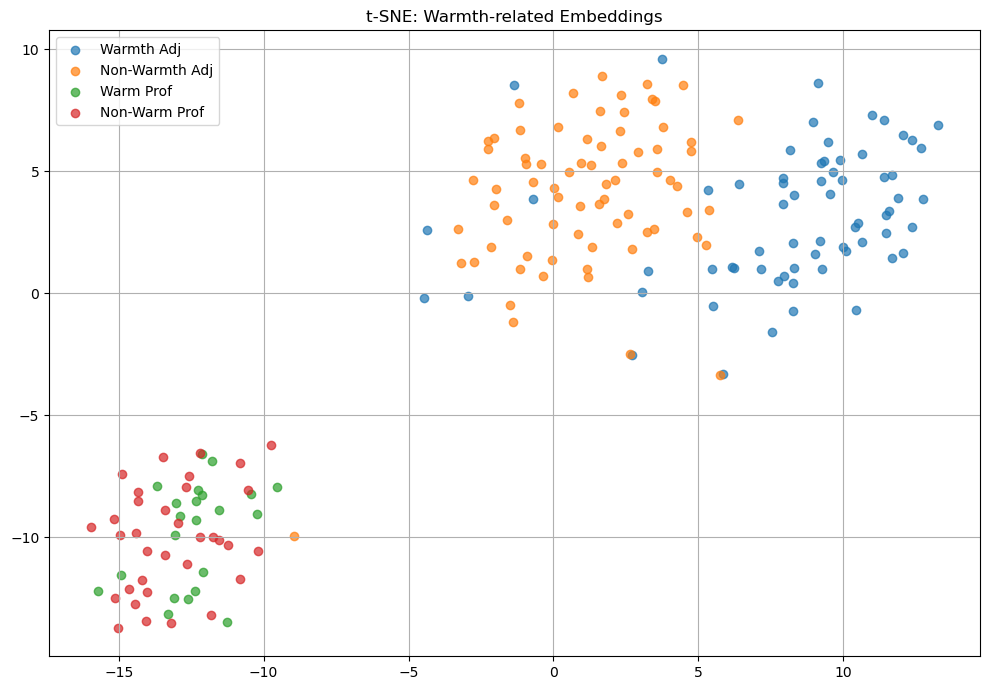

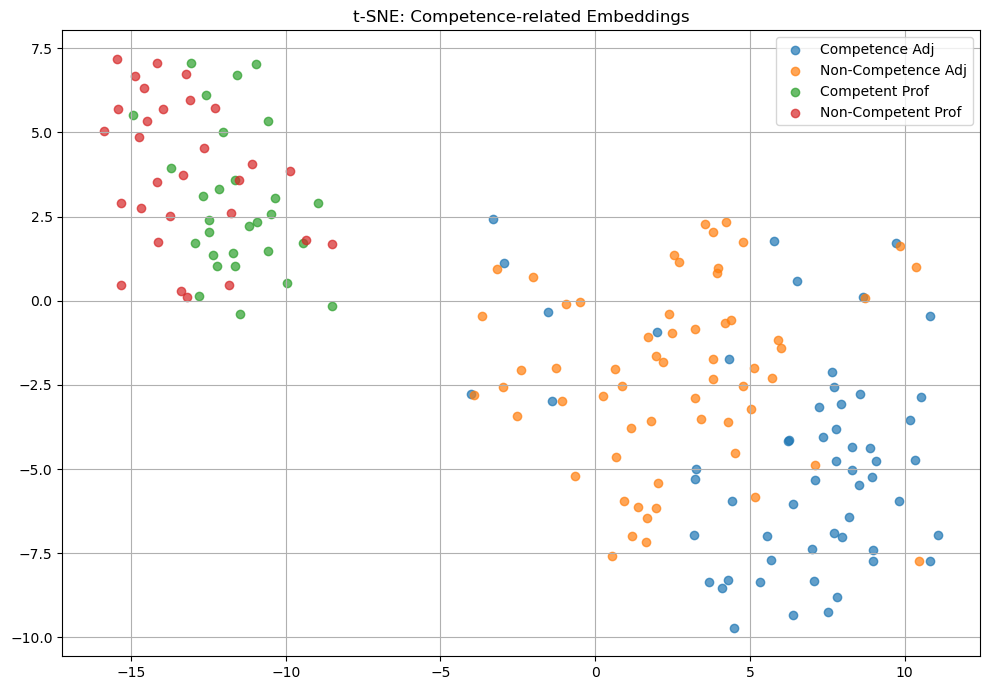

In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_tsne(embeddings_dict, title="t-SNE Projection of Embeddings"):
    #flatten and prepare all embeddings
    all_embeddings = torch.cat(list(embeddings_dict.values()), dim=0).numpy()
    all_labels = sum([[label] * len(emb) for label, emb in embeddings_dict.items()], [])

    #apply t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(all_embeddings)

    #plot
    plt.figure(figsize=(10, 7))
    for label in embeddings_dict:
        idx = [i for i, l in enumerate(all_labels) if l == label]
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=label, alpha=0.7)

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

visualize_tsne({
    "Warmth Adj": warmth_emb,
    "Non-Warmth Adj": non_warmth_emb,
    "Warm Prof": prof_warm_emb,
    "Non-Warm Prof": prof_nonwarm_emb
}, title="t-SNE: Warmth-related Embeddings")

visualize_tsne({
    "Competence Adj": competence_emb,
    "Non-Competence Adj": non_competence_emb,
    "Competent Prof": prof_competence_emb,
    "Non-Competent Prof": prof_non_competence_emb
}, title="t-SNE: Competence-related Embeddings")


In [24]:
#project back with average sim to bias directions
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertForMaskedLM

#loading custom bias directions
warmth_vector = pd.read_csv('/Users/aleksandragarbat/Desktop/Thesis/warmth_direction.csv').values.flatten()
competence_vector = pd.read_csv('/Users/aleksandragarbat/Desktop/Thesis/competence_direction.csv').values.flatten()

warmth_vector = torch.tensor(warmth_vector, dtype=torch.float32)
competence_vector = torch.tensor(competence_vector, dtype=torch.float32)

#normalizing bias direction vectors
warmth_vector = warmth_vector / warmth_vector.norm()
competence_vector = competence_vector / competence_vector.norm()

model_path = "/Users/aleksandragarbat/Desktop/BERT_baseline"

#load model and tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForMaskedLM.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

def get_profession_embedding(profession):
    sentence = f"The {profession} is a person."
    inputs = tokenizer(sentence, return_tensors='pt').to(device)
    with torch.no_grad():
        outputs = model.bert(**inputs)
    emb = outputs.last_hidden_state.mean(dim=1).squeeze()  # [hidden_size]
    return emb.cpu()

def cosine_similarity(vec1, vec2):
    # Both vectors are 1D tensors
    vec1 = vec1 / vec1.norm()
    vec2 = vec2 / vec2.norm()
    return torch.dot(vec1, vec2).item()

def cosine_similarity_scores(professions, direction_vector):
    direction_vector = direction_vector.to(device)
    cos_sims = {}
    for prof in professions:
        emb = get_profession_embedding(prof).to(device)
        sim = cosine_similarity(emb, direction_vector)
        cos_sims[prof] = sim
    return cos_sims

professions = [
    "professor", "vet", "paramedic", "chef", "dentist", "maid", "doctor", "nurse",
    "scientist", "welder", "teacher", "waiter", "mechanic", "police", "secretary",
    "psychiatrist", "farmer", "pilot", "director", "architect", "c.e.o", "artist",
    "writer", "fisherman", "medical assistant", "manager", "librarian", "politician",
    "engineer", "bartender", "accountant", "firefighter", "travel agent", "lawyer",
    "actor", "lab technician", "security guard", "custodian", "childcare worker",
    "bank teller", "taxi driver", "bus driver", "news anchor", "customer service representative",
    "cashier", "plumber", "technical support worker", "electrician", "graphic designer",
    "financial advisor", "salesperson", "truck driver", "landscaper", "postal worker",
    "factory worker", "garbage collector", "computer programmer", "construction worker"
]

#calculating cosine similarity scores
warmth_cosine_scores = cosine_similarity_scores(professions, warmth_vector)
competence_cosine_scores = cosine_similarity_scores(professions, competence_vector)

print("\n--- Warmth Cosine Similarities ---")
for p, score in sorted(warmth_cosine_scores.items(), key=lambda x: -x[1]):
    print(f"{p:25} : {score:.4f}")

print("\n--- Competence Cosine Similarities ---")
for p, score in sorted(competence_cosine_scores.items(), key=lambda x: -x[1]):
    print(f"{p:25} : {score:.4f}")




#averages
avg_warmth = np.mean(list(warmth_cosine_scores.values()))
avg_competence = np.mean(list(competence_cosine_scores.values()))

print(f"Average Warmth Cosine Similarity: {avg_warmth:.4f}")
print(f"Average Competence Cosine Similarity: {avg_competence:.4f}")


--- Warmth Cosine Similarities ---
paramedic                 : 0.0182
politician                : -0.0962
medical assistant         : -0.0995
dentist                   : -0.1043
nurse                     : -0.1078
doctor                    : -0.1089
vet                       : -0.1116
professor                 : -0.1165
artist                    : -0.1165
librarian                 : -0.1178
teacher                   : -0.1178
writer                    : -0.1196
psychiatrist              : -0.1225
actor                     : -0.1230
firefighter               : -0.1272
police                    : -0.1287
childcare worker          : -0.1349
scientist                 : -0.1400
director                  : -0.1410
c.e.o                     : -0.1425
travel agent              : -0.1427
pilot                     : -0.1515
architect                 : -0.1534
bus driver                : -0.1534
farmer                    : -0.1536
taxi driver               : -0.1536
secretary                 : -

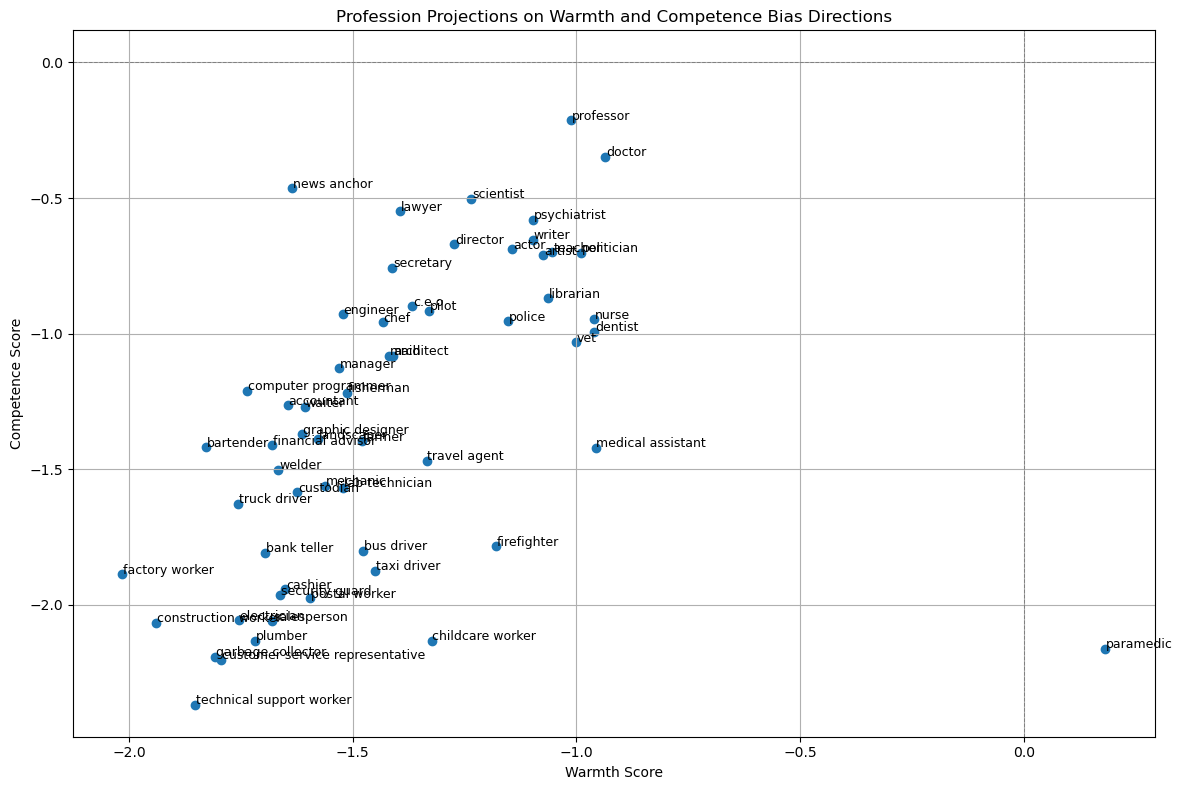

In [26]:
####plot for projections
import matplotlib.pyplot as plt

#preparing coordinates x and y
x_vals = [warmth_scores[prof] for prof in professions]
y_vals = [competence_scores[prof] for prof in professions]

plt.figure(figsize=(12, 8))
plt.scatter(x_vals, y_vals)

#adding profession labels
for i, prof in enumerate(professions):
    plt.text(x_vals[i] + 0.002, y_vals[i] + 0.002, prof, fontsize=9)

plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.7)
plt.title("Profession Projections on Warmth and Competence Bias Directions")
plt.xlabel("Warmth Score")
plt.ylabel("Competence Score")
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
#embeddings extraction
from tqdm import tqdm
from transformers import BertTokenizer, BertForMaskedLM
import torch
import csv

#loading model and tokenizer
model_path = "/Users/aleksandragarbat/Desktop/BERT_baseline"
model.to(device)
model.eval()

def get_profession_embedding(profession, model, tokenizer, device):
    sentence = f"The {profession} is there."  # neutral context
    inputs = tokenizer(sentence, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.bert(**inputs, return_dict=True)
        hidden_states = outputs.last_hidden_state.squeeze(0)  # shape: [seq_len, hidden_dim]

    tokens = tokenizer.tokenize(sentence)
    profession_tokens = tokenizer.tokenize(profession)

    #finding start index of profession tokens
    for i in range(len(tokens) - len(profession_tokens) + 1):
        if tokens[i:i+len(profession_tokens)] == profession_tokens:
            start, end = i, i + len(profession_tokens)
            break
    else:
        raise ValueError(f"Could not find token span for profession: {profession}")

    #get mean embedding over profession token span
    profession_embedding = hidden_states[start+1:end+1].mean(dim=0)  # +1 due to [CLS] token at position 0
    return profession_embedding.cpu()

import pandas as pd

professions = [
    "professor", "vet", "paramedic", "chef", "dentist", "maid", "doctor", "nurse",
    "scientist", "welder", "teacher", "waiter", "mechanic", "police", "secretary",
    "psychiatrist", "farmer", "pilot", "director", "architect", "c.e.o", "artist",
    "writer", "fisherman", "medical assistant", "manager", "librarian", "politician",
    "engineer", "bartender", "accountant", "firefighter", "travel agent", "lawyer",
    "actor", "lab technician", "security guard", "custodian", "childcare worker",
    "bank teller", "taxi driver", "bus driver", "news anchor", "customer service representative",
    "cashier", "plumber", "technical support worker", "electrician", "graphic designer",
    "financial advisor", "salesperson", "truck driver", "landscaper", "postal worker",
    "factory worker", "garbage collector", "computer programmer", "construction worker"
]

embedding_dict = {}
for prof in tqdm(professions):
    try:
        emb = get_profession_embedding(prof, model, tokenizer, device)
        embedding_dict[prof] = emb.numpy()
    except Exception as e:
        print(f"Could not extract embedding for {prof}: {e}")

#saving to csv
csv_path = "profession_embeddings_baseline.csv"
with open(csv_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    
    #determining the dimension from one of the embeddings
    dim = next(iter(embedding_dict.values())).shape[0]
    
    #headers: ["Profession", "dim_0", "dim_1", .., "dim_n" and so on]
    header = ["Profession"] + [f"dim_{i}" for i in range(dim)]
    writer.writerow(header)
    
    #each profession and its embedding 
    for prof, emb in embedding_dict.items():
        row = [prof] + emb.tolist()
        writer.writerow(row)

print(f"Saved profession embeddings to {csv_path}")



100%|███████████████████████████████████████████| 58/58 [00:04<00:00, 12.41it/s]


Saved profession embeddings to profession_embeddings_baseline.csv
